In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pydicom import dcmread
import os
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt


from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import re
from glob import glob
from wad import Dict

In [2]:
DATA_ROOT="../data/"
def filt(tgt,str_list):
    return sorted([*filter(lambda x: tgt in x, str_list)])

src_dcm=glob(DATA_ROOT+f"train/**/*.dcm",recursive=True)
src_png=glob(DATA_ROOT+f"train/**/*.png",recursive=True)
src_f=Dict(**{
    y_kw:list(zip(filt(x_kw,src_dcm),filt(y_kw,src_png)))
    for x_kw,y_kw in [('CT','CT'),('InPhase','T1DUAL'),('OutPhase','OutPhase'),('T2SPIR','T2SPIR')]
})
tgt_dcm=glob(DATA_ROOT+f"test/**/*.dcm",recursive=True)
tgt_f=Dict(**{
    x_kw:filt(x_kw,tgt_dcm)
    for x_kw in ['CT','T1DUAL','T2SPIR']
})

In [9]:
import cv2
def load_patient(patient_files):
    slices = [dcmread(s[0]) for s in patient_files]
    masks = np.stack([(cv2.imread(m[1])[...,0]==255) for m in patient_files])
    image = np.stack([s.pixel_array for s in slices]).astype("float")
    slope = float(slices[0].RescaleSlope)
    if slope != 1:
        image = slope * image
    return image,masks

In [10]:
nums=[1,2,5,6,8]


In [29]:
num=nums[3]
patient=[*filter(lambda x: f'/{num}/' in x[0], src_f.CT)]
image,masks=load_patient(patient)
b=image.copy()
# b[(b>800)&(b>1300)]=b[(b>800)&(b>1300)]*5
# b[b>1300]=b[b>1300]*5
b=b-b.min()
b=b/(b.max()-b.min())

In [32]:
%matplotlib widget
from ipywidgets import interact
def f(slice_num,contour_num):
    plt.close()
    plt.figure(figsize=(10,5))
    ret, thresh = cv2.threshold((b[slice_num]*255).astype("uint8"), 110, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours=np.squeeze(sorted(contours, key=len,reverse=True)[contour_num])
    filled_contour=cv2.fillPoly(np.zeros_like(b[slice_num],dtype="uint8"), pts =[contours], color=255)
    plt.subplot(1,3,1)
    plt.imshow(b[slice_num],"gray")
    plt.subplot(1,3,2)
    plt.imshow(masks[slice_num],"gray")
    plt.subplot(1,3,3)
    plt.imshow(filled_contour,"gray")
    
interact(f,slice_num=(0,len(b)-1),contour_num=0)

interactive(children=(IntSlider(value=43, description='slice_num', max=87), IntSlider(value=0, description='co…

<function __main__.f(slice_num, contour_num)>

In [22]:
slice_num=40
contour_num=0
ret, thresh = cv2.threshold((b[slice_num]*255).astype("uint8"), 100, 110, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours=np.squeeze(sorted(contours, key=len,reverse=True)[contour_num])
filled_contour=cv2.fillPoly(np.zeros_like(b[slice_num],dtype="uint8"), pts =[contours], color=255)

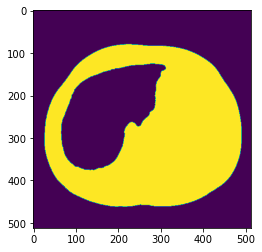

In [271]:
%matplotlib inline
trunk=np.logical_xor(masks[slice_num],filled_contour)
plt.imshow(trunk)

In [274]:
cv2.imwrite(f"tmp.png",trunk*255)

True